In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

import os, shutil, pathlib

tf.config.list_physical_devices()

2022-08-10 00:10:46.769793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 00:10:46.774058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 00:10:46.774262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
orginal_dir = pathlib.Path("/home/ashok/workspace/dataset/PetImages/")
new_base_dir = pathlib.Path("/home/ashok/workspace/dataset/cats_vs_dogs_small/")

train_dataset = keras.utils.image_dataset_from_directory(
    new_base_dir/"train",
    image_size=(180,180),
    batch_size=32
)

val_dataset = keras.utils.image_dataset_from_directory(
    new_base_dir/"validation",
    image_size=(180,180),
    batch_size=32
)

test_dataset = keras.utils.image_dataset_from_directory(
    new_base_dir/"test",
    image_size=(180,180),
    batch_size=32
)

Found 1875 files belonging to 2 classes.
Found 941 files belonging to 2 classes.
Found 1862 files belonging to 2 classes.


In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180,180,3)
)

2022-08-10 00:10:46.854968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 00:10:46.855939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 00:10:46.856225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 00:10:46.856364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

58889256/58889256 [==============================] - 4s 0us/step


In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION**

In [5]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

In [7]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

2022-08-10 00:26:12.772658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-10 00:26:13.255642: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-10 00:26:13.256184: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-10 00:26:13.256204: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-10 00:26:13.256773: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-10 00:26:13.256821: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 0s 15ms/step


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 15ms/step


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1/1 [==============================] - 1s 785ms/step


In [9]:
# instead of 1875 images of shape 180x180x3, now we have 1875 images of shape 5x5 with 512 channels(filters)

train_features.shape

(1875, 5, 5, 512)

In [10]:
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/ch08-convnets-from-scratch/feature-extraction.keras",
        save_best_only = True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/30


2022-08-10 00:34:34.383165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 96000000 exceeds 10% of free system memory.
2022-08-10 00:34:34.416039: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 96000000 exceeds 10% of free system memory.


48/59 [=======================>......] - ETA: 0s - loss: 18.4364 - accuracy: 0.9128

2022-08-10 00:34:35.099558: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48179200 exceeds 10% of free system memory.
2022-08-10 00:34:35.121336: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48179200 exceeds 10% of free system memory.


59/59 [==============================] - 1s 7ms/step - loss: 16.5642 - accuracy: 0.9189 - val_loss: 6.0509 - val_accuracy: 0.9575
Epoch 2/30
59/59 [==============================] - 0s 5ms/step - loss: 2.8415 - accuracy: 0.9755 - val_loss: 4.6718 - val_accuracy: 0.9660
Epoch 3/30
59/59 [==============================] - 0s 5ms/step - loss: 3.4651 - accuracy: 0.9744 - val_loss: 4.1709 - val_accuracy: 0.9734
Epoch 4/30
59/59 [==============================] - 0s 4ms/step - loss: 0.8053 - accuracy: 0.9931 - val_loss: 8.7623 - val_accuracy: 0.9628
Epoch 5/30
59/59 [==============================] - 0s 4ms/step - loss: 1.4467 - accuracy: 0.9920 - val_loss: 5.9172 - val_accuracy: 0.9745
Epoch 6/30
59/59 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.9952 - val_loss: 7.0339 - val_accuracy: 0.9649
Epoch 7/30
59/59 [==============================] - 0s 4ms/step - loss: 0.3267 - accuracy: 0.9968 - val_loss: 6.7187 - val_accuracy: 0.9702
Epoch 8/30
59/59 [============

<Figure size 432x288 with 0 Axes>

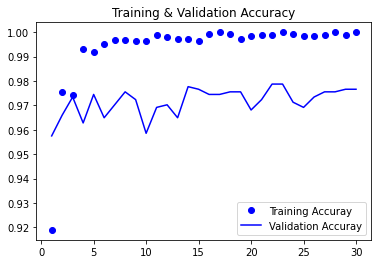

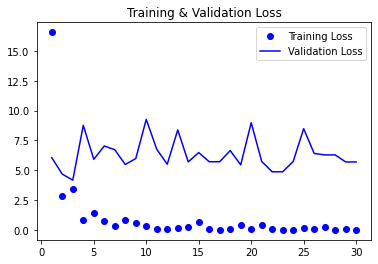

<Figure size 432x288 with 0 Axes>

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training Accuray")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuray")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.figure()

**FEATURE EXTRACTION WITH DATA AUGMENTATION**

In [12]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)
conv_base.trainable = False

Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 19.3451 - accuracy: 0.8912

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 178ms/step - loss: 19.3451 - accuracy: 0.8912 - val_loss: 4.2514 - val_accuracy: 0.9734
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 8.4114 - accuracy: 0.9360

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 10s 177ms/step - loss: 8.4114 - accuracy: 0.9360 - val_loss: 8.3646 - val_accuracy: 0.9511
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 7.4503 - accuracy: 0.9419

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 178ms/step - loss: 7.4503 - accuracy: 0.9419 - val_loss: 4.9480 - val_accuracy: 0.9692
Epoch 4/10
59/59 [==============================] - ETA: 0s - loss: 4.6284 - accuracy: 0.9557

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 178ms/step - loss: 4.6284 - accuracy: 0.9557 - val_loss: 8.1220 - val_accuracy: 0.9617
Epoch 5/10
59/59 [==============================] - ETA: 0s - loss: 4.6586 - accuracy: 0.9616

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 179ms/step - loss: 4.6586 - accuracy: 0.9616 - val_loss: 12.8411 - val_accuracy: 0.9426
Epoch 6/10
59/59 [==============================] - ETA: 0s - loss: 4.2499 - accuracy: 0.9691

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 179ms/step - loss: 4.2499 - accuracy: 0.9691 - val_loss: 6.4004 - val_accuracy: 0.9671
Epoch 7/10
59/59 [==============================] - ETA: 0s - loss: 3.5030 - accuracy: 0.9648

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 180ms/step - loss: 3.5030 - accuracy: 0.9648 - val_loss: 6.8839 - val_accuracy: 0.9639
Epoch 8/10
59/59 [==============================] - ETA: 0s - loss: 2.6163 - accuracy: 0.9760

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 179ms/step - loss: 2.6163 - accuracy: 0.9760 - val_loss: 4.9530 - val_accuracy: 0.9660
Epoch 9/10
59/59 [==============================] - ETA: 0s - loss: 2.6051 - accuracy: 0.9739

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 182ms/step - loss: 2.6051 - accuracy: 0.9739 - val_loss: 2.6197 - val_accuracy: 0.9787
Epoch 10/10
59/59 [==============================] - ETA: 0s - loss: 3.1341 - accuracy: 0.9717

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


19/59 [========>.....................] - ETA: 3s - loss: 4.3762 - accuracy: 0.9671

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


59/59 [==============================] - 6s 96ms/step - loss: 4.2586 - accuracy: 0.9683
test accuracy: 0.968


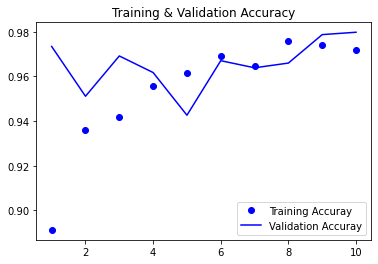

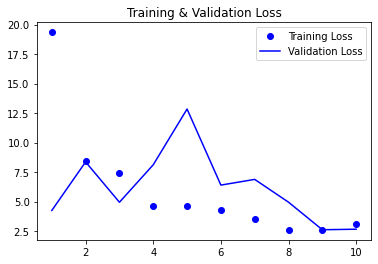

<Figure size 432x288 with 0 Axes>

In [13]:
data_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape=(180,180,3))
x = data_aug(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/ch08-convnets-from-scratch/feature_extraction_with_data_augmentation.keras",
        save_best_only = True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training Accuray")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuray")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.figure()

test_model = keras.models.load_model("checkpoints/ch08-convnets-from-scratch/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test accuracy: {test_acc:.3f}")

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**FINE-TUNING A PRTRAINED MODEL**

In [18]:
conv_base.layers[:-4]

In [19]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 1.5664 - accuracy: 0.9797

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 12s 185ms/step - loss: 1.5664 - accuracy: 0.9797 - val_loss: 2.0648 - val_accuracy: 0.9798
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 1.1573 - accuracy: 0.9813

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 181ms/step - loss: 1.1573 - accuracy: 0.9813 - val_loss: 2.0664 - val_accuracy: 0.9819
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.9824

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 186ms/step - loss: 0.9373 - accuracy: 0.9824 - val_loss: 1.8149 - val_accuracy: 0.9798
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 0.9262 - accuracy: 0.9867

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 188ms/step - loss: 0.9262 - accuracy: 0.9867 - val_loss: 1.4501 - val_accuracy: 0.9819
Epoch 5/30
59/59 [==============================] - ETA: 0s - loss: 1.0507 - accuracy: 0.9819

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 188ms/step - loss: 1.0507 - accuracy: 0.9819 - val_loss: 1.3441 - val_accuracy: 0.9830
Epoch 6/30
59/59 [==============================] - ETA: 0s - loss: 0.6588 - accuracy: 0.9867

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 184ms/step - loss: 0.6588 - accuracy: 0.9867 - val_loss: 1.5929 - val_accuracy: 0.9830
Epoch 7/30
59/59 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.9867

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 185ms/step - loss: 0.4861 - accuracy: 0.9867 - val_loss: 1.4617 - val_accuracy: 0.9819
Epoch 8/30
59/59 [==============================] - ETA: 0s - loss: 0.7933 - accuracy: 0.9883

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 187ms/step - loss: 0.7933 - accuracy: 0.9883 - val_loss: 2.9135 - val_accuracy: 0.9734
Epoch 9/30
59/59 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.9893

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 187ms/step - loss: 0.4934 - accuracy: 0.9893 - val_loss: 1.6024 - val_accuracy: 0.9819
Epoch 10/30
59/59 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9899

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 188ms/step - loss: 0.2595 - accuracy: 0.9899 - val_loss: 1.9757 - val_accuracy: 0.9819
Epoch 11/30
59/59 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.9931

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 188ms/step - loss: 0.3035 - accuracy: 0.9931 - val_loss: 1.4661 - val_accuracy: 0.9851
Epoch 12/30
59/59 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.9883

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 189ms/step - loss: 0.5485 - accuracy: 0.9883 - val_loss: 1.5433 - val_accuracy: 0.9787
Epoch 13/30
59/59 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.9888

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 188ms/step - loss: 0.3001 - accuracy: 0.9888 - val_loss: 1.5894 - val_accuracy: 0.9809
Epoch 14/30
59/59 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.9909

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 192ms/step - loss: 0.3783 - accuracy: 0.9909 - val_loss: 1.3270 - val_accuracy: 0.9798
Epoch 15/30
59/59 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.9915

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 192ms/step - loss: 0.3851 - accuracy: 0.9915 - val_loss: 1.2062 - val_accuracy: 0.9819
Epoch 16/30
59/59 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9925

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 190ms/step - loss: 0.2172 - accuracy: 0.9925 - val_loss: 1.4581 - val_accuracy: 0.9830
Epoch 17/30
59/59 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.9909

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 191ms/step - loss: 0.2578 - accuracy: 0.9909 - val_loss: 1.6066 - val_accuracy: 0.9777
Epoch 18/30
59/59 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9952

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 189ms/step - loss: 0.1568 - accuracy: 0.9952 - val_loss: 1.7443 - val_accuracy: 0.9819
Epoch 19/30
59/59 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9952

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 191ms/step - loss: 0.1796 - accuracy: 0.9952 - val_loss: 1.6559 - val_accuracy: 0.9809
Epoch 20/30
59/59 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9968

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 191ms/step - loss: 0.1177 - accuracy: 0.9968 - val_loss: 1.3286 - val_accuracy: 0.9819
Epoch 21/30
59/59 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9941

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 191ms/step - loss: 0.1236 - accuracy: 0.9941 - val_loss: 1.5307 - val_accuracy: 0.9777
Epoch 22/30
59/59 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.9957

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 191ms/step - loss: 0.2528 - accuracy: 0.9957 - val_loss: 1.5140 - val_accuracy: 0.9798
Epoch 23/30
59/59 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.9925

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 192ms/step - loss: 0.2526 - accuracy: 0.9925 - val_loss: 1.6642 - val_accuracy: 0.9756
Epoch 24/30
59/59 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9925

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 191ms/step - loss: 0.2113 - accuracy: 0.9925 - val_loss: 1.8760 - val_accuracy: 0.9787
Epoch 25/30
59/59 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9973

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 191ms/step - loss: 0.0372 - accuracy: 0.9973 - val_loss: 1.5475 - val_accuracy: 0.9756
Epoch 26/30
59/59 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9931

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 194ms/step - loss: 0.1620 - accuracy: 0.9931 - val_loss: 1.7845 - val_accuracy: 0.9756
Epoch 27/30
59/59 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9936

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 192ms/step - loss: 0.1768 - accuracy: 0.9936 - val_loss: 1.7411 - val_accuracy: 0.9809
Epoch 28/30
59/59 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.9936

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 193ms/step - loss: 0.3243 - accuracy: 0.9936 - val_loss: 2.2191 - val_accuracy: 0.9787
Epoch 29/30
59/59 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9973

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 11s 192ms/step - loss: 0.1819 - accuracy: 0.9973 - val_loss: 1.9967 - val_accuracy: 0.9809
Epoch 30/30
59/59 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9952

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


19/59 [========>.....................] - ETA: 4s - loss: 1.9746 - accuracy: 0.9688

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


59/59 [==============================] - 6s 100ms/step - loss: 2.0767 - accuracy: 0.9731
test accuracy: 0.973


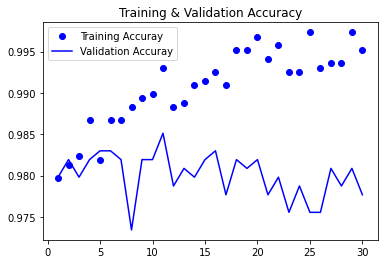

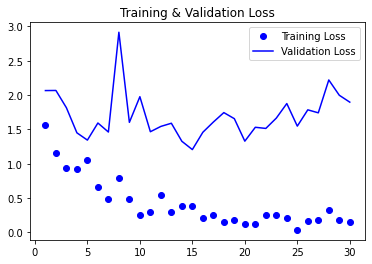

<Figure size 432x288 with 0 Axes>

In [20]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/ch08-convnets-from-scratch/fine_tuining.keras",
        save_best_only = True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training Accuray")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuray")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.figure()

test_model = keras.models.load_model("checkpoints/ch08-convnets-from-scratch/fine_tuining.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test accuracy: {test_acc:.3f}")